In [1]:
%matplotlib inline

In [2]:
import os
import glob
import json
import xml.etree.ElementTree as ET

import cv2
import pandas
import openslide
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import chain
import matplotlib.pyplot as plt

from pyslyde import Slide, WSIParser, Stitching, Annotations
from pyslyde.util.utilities import mask2rgb
from pyslyde.util.utilities import calculate_weights, calculate_std_mean
from pyslyde.util.utilities import TissueDetect, visualise_wsi_tiling

/opt/anaconda3/envs/pyslyde/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 📁 Datasets

The datasets used in this notebook can be found at the following Google Drive link:

👉 [Access the dataset here](https://drive.google.com/drive/folders/1fkr3kGlfwpZiv8i3Xfzl29OaUtvR2fj-?usp=drive_link)


In [3]:
folder_path = '/Users/k2481276/Documents/PySlyde/'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder created: {folder_path}")
else:
    print(f"Folder already exists: {folder_path}")

Folder already exists: /Users/k2481276/Documents/PySlyde/


In [4]:
class Args():
    def __init__(self):
        self.mag_level=1
        self.stride = 512
        self.tile_dims = 512
        self.filter_threshold = 0.5
        self.sample = 1000
        self.parser = 'tiler'
        self.downsample = 1
        self.normalize = None
        self.database = 'lmdb'
        self.map_size = 1e6
        self.model_path = folder_path + 'output'
        self.tile_path = folder_path + 'output/tiles'
        self.name = 'sample_test'

args = Args()

## Whole-Slide Images with `Slide`

The `Slide` class wraps `openslide.OpenSlide`, adding built-in support for annotation masks, border detection, and region extraction:

- **Core functionality**  
  - Inherits all OpenSlide methods (e.g. `read_region`, `get_thumbnail`)  
  - Accepts `annotations` or `annotations_path` to overlay ROI files  

- **Mask generation**  
  - `generate_mask(size=None, labels=[])` → single-channel array where each pixel value is the integer class ID (0 = background)  
  - `slide_mask` → RGB-colorized full-slide mask at fixed `(2000×2000)`  

- **Border detection**  
  - `get_border(space=100)` → returns `[(x_min,x_max),(y_min,y_max)]` around all annotations (or full slide if none)  
  - `Slide.resize_border(dim, factor, threshold, operator)` → snap any dimension to nearest multiple of `factor` meeting a threshold rule  

- **Component detection**  
  - `detect_components(level_dims=6, num_component=None, min_size=None)`  
    - Finds contours on downsampled thumbnail  
    - Returns `(cropped_component_images, borders)` for the largest regions  

- **Region extraction**  
  - `generate_region(`  
  &nbsp;&nbsp;`mag=0, x=None, y=None, x_size=None, y_size=None,`  
  &nbsp;&nbsp;`scale_border=False, factor=1, threshold=None, operator='=>'`  
  `)`  
  - If `x,y` omitted → uses `.get_border()`  
  - Optionally applies `resize_border` before cropping  
  - Returns `(RGB_array, mask_array)` for the specified region  

- **Saving outputs**  
  - `save(path, size=(2000,2000), mask=False)`  
    - `mask=False` → saves a downsampled thumbnail image  
    - `mask=True`  → saves the colorized slide mask  

---

### Initialization

```python
Slide(
    filename,             # str: path to WSI file
    mag=0,                # int: magnification level (0=base, 1=2×, etc.)
    annotations=None,     # Annotations object (optional)
    annotations_path=None,# str or [str]: path(s) to annotation file(s)
    labels=None,          # list[str]: subset of labels to load
    source=None           # "imagej"|"asap"|"qupath"|"json"|"csv"|"_dataframe"
)


In [5]:
WSI_PATH = folder_path + 'test_data/2865_B2_LN.ndpi'

In [6]:
try:
    resolved_path = os.path.realpath(WSI_PATH)
    wsi = Slide(resolved_path)
    print(wsi)
except openslide.lowlevel.OpenSlideError as e:
    err_msg = f'Failed to open WSI file {WSI_PATH} with resolved path {resolved_path}: {e}.'
    print(err_msg)

Slide('/Users/k2481276/Documents/PySlyde/test_data/2865_B2_LN.ndpi')


Base mag: 40, mpp: 0.2201188641866608


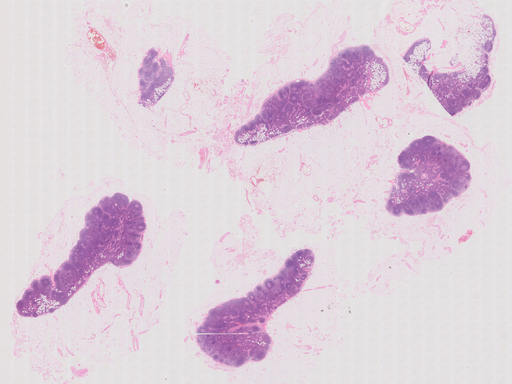

In [7]:
base_mag = wsi.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER]
mpp = wsi.properties[openslide.PROPERTY_NAME_MPP_X]
print(f'Base mag: {base_mag}, mpp: {mpp}')
wsi.get_thumbnail((512,512))

### Border rounding, component detection & region extraction

This cell performs several steps to find and crop a segmented tissue region:

1. **Compute & print the padded border**  
   ```python
   border = wsi.get_border()
   print(f"Border (with 100 px padding): {border}")
   ```

Returns a tuple ((x1,x2),(y1,y2)) around all annotations.

2. **Downsample border origin by 32**
   ```python
   x_snapped = Slide.resize_border(border[0][0], factor=32)
    ```

3. **Detect connected tissue components**
    ```python
    components, comp_borders = wsi.detect_components()
    plt.imshow(components[-1]); plt.axis('off')
    ```
   
Finds contours on the level-6 thumbnail, returns a list of component images and their level-0 borders; here we display the last one.

    

In [8]:
print('border:{}'.format(wsi.get_border()))
borders=wsi.get_border()
x_new=wsi.resize_border(borders[0][0],factor=32)

border:[(0, 129024), (0, 96768)]


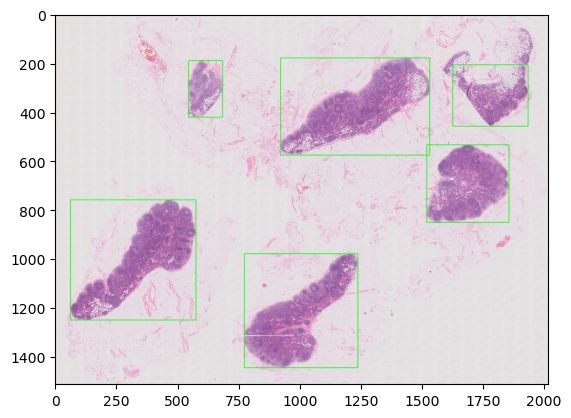

In [9]:
img, borders = wsi.detect_components(num_component=6)
plt.imshow(img[-1])
plt.show()

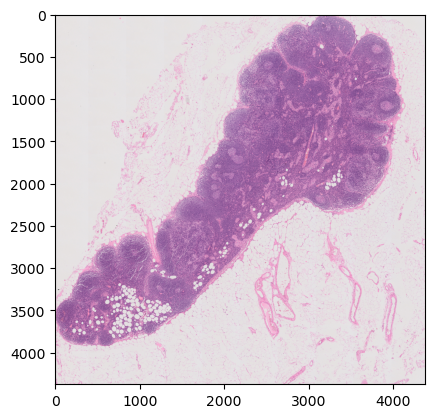

In [10]:
border=borders[-1]
(x1,y1),(x2,y2)=(border[0][0],border[1][0]),(border[1][0],border[1][1])
region=wsi.generate_region(mag=3,x=(x1,x2),y=(y1,y2),x_size=35000,y_size=35000)
plt.imshow(region[0])
plt.show()

Contour mask shape (3024, 4032)


/Users/k2481276/Documents/PySlyde/pyslyde/util/utilities.py:248: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  mask = opening(closing(thresh, footprint=square(2)), footprint=square(2))


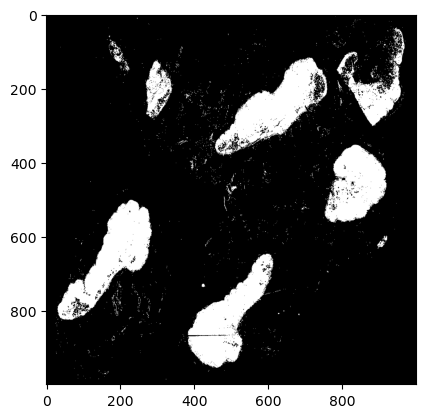

In [11]:
ds_factors = [int(d) for d in wsi.level_downsamples]
level = ds_factors.index(32) if 32 in ds_factors else ds_factors.index(int(ds_factors[-1]))
detector = TissueDetect(wsi)
thumb = detector.tissue_thumbnail
tis_mask = detector.detect_tissue()
border = detector.border()
plt.imshow(cv2.resize(tis_mask,(1000,1000)),cmap='gray')
plt.show()

## Tile & Feature Extraction with `WSIParser`

The `WSIParser` class manages tiling and (optionally) feature extraction from a whole-slide image:

- **Core functionality**  
  - Wraps an `OpenSlide` (or `Slide`) instance  
  - Defines a regular grid of tiles over a given `border` at `mag_level`  
  - Optional stain normalization via a `stain_normalizer`  

- **Tile grid generation**  
  - `tiler(stride=None, edge_cases=False)` → populates `parser.tiles` with `(x,y)` coordinates for each patch; returns total count  
  - Honors image border and downsampling factor  

- **Tile extraction**  
  - `extract_tile(x, y)` → reads one patch at `(x,y)` as an RGB `ndarray`  
  - `extract_tiles(normalize=False)` → generator yielding `( (x,y), tile_array )` for every tile  

- **Feature extraction**  
  - `extract_features(model_name, model_path, device=None, downsample=None, normalize=False)` → generator yielding `( (x,y), feature_vector )` using a pre-trained model  

- **Filtering & sampling**  
  - `filter_tissue(slide_mask, label, threshold=0.5)` → removes tiles with insufficient tissue of given class  
  - `filter_tiles(filter_func, *args, **kwargs)` → applies arbitrary boolean filter to each tile  
  - `sample_tiles(n)` → randomly selects `n` tiles from the grid  

- **Saving outputs**  
  - `save(func, tile_path, label_dir=False, label_csv=False, normalize=False)` → writes tiles or features to disk via a generator `func`  
  - `to_lmdb(func, db_path, map_size, write_frequency=10)` → store outputs in LMDB  
  - `to_rocksdb(func, db_path, write_frequency=10)` → store outputs in RocksDB  
  - `feat_to_disk(func, path, write_frequency=10)` → write features to filesystem  

---

### Initialization

```python
from wsi_parser import WSIParser

parser = WSIParser(
    slide=slide,                  # OpenSlide or Slide instance
    tile_dim=256,                 # tile width & height in pixels
    border=[(x_min,x_max),(y_min,y_max)],  
    mag_level=0,                  # pyramid level index (0 = native)
    stain_normalizer=None         # optional stain normalizer
)


parser.number      # int: number of tiles generated
parser.tiles       # List[(x, y)]: tile coordinate list
parser.config      # dict: { name, mag, size, border, number }


In [12]:
#SN_TARGET = 
#SN_METHOD = 
TILE_DIMS = 512
STRIDE = 512
MAG_LEVEL = 1

#normalizer = StainNormalizer(sn_target, sn_method)
normalize = None
parser = WSIParser(wsi, tile_dim=TILE_DIMS, border=border, mag_level=MAG_LEVEL)
num = parser.tiler(stride=STRIDE)
print(f'Tiles: {num}')

downsample 2
Tiles: 10440


In [13]:
FILTER_THRESHOLD = 0.1

parser.filter_tissue(
    tis_mask,
    label=1,
    threshold=FILTER_THRESHOLD)
print(f'Filtered tiles: {parser.number}')

Filtered tiles: 2035


In [14]:
VIS_PATH = folder_path + 'output'
NAME = 'leap_test'

visualise_wsi_tiling(
        wsi,
        parser,
        os.path.join(VIS_PATH,
                     NAME+'_tiling.png'),
        viewing_res=level
        )

_x_dims 1024
saving where /Users/k2481276/Documents/PySlyde/output/leap_test_tiling.png


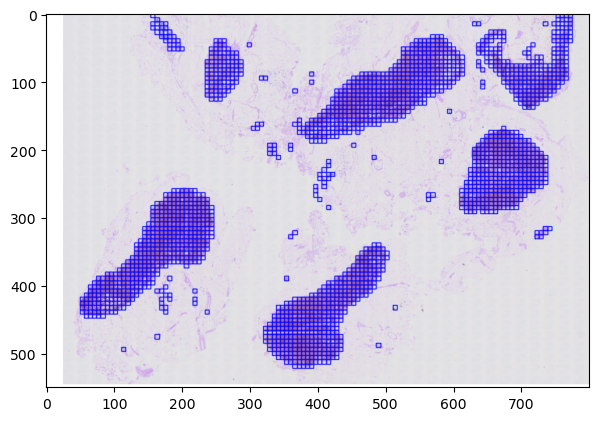

In [15]:
%matplotlib inline
img = cv2.imread(folder_path + 'output/leap_test_tiling.png')
plt.figure(figsize=(7,7))
plt.imshow(img[250:800,100:900])

Sampled tiles: 250
_x_dims 1024
saving where /Users/k2481276/Documents/PySlyde/output/sample_test_tiling.png


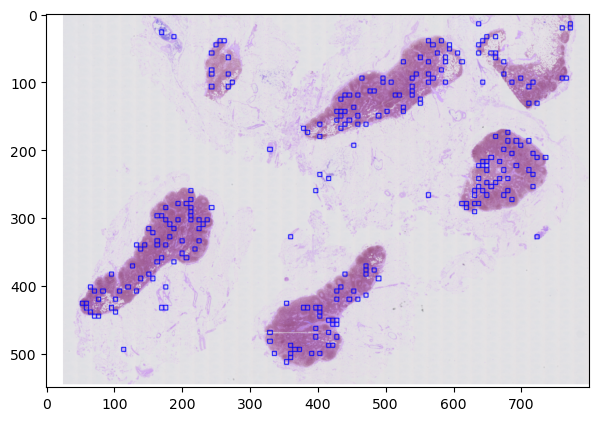

In [16]:
NAME = 'sample_test'
SAMPLE = 250

parser.sample_tiles(SAMPLE)
print(f'Sampled tiles: {parser.number}')

visualise_wsi_tiling(
        wsi,
        parser,
        os.path.join(VIS_PATH,
                     NAME+'_tiling.png'),
        viewing_res=level
        )

%matplotlib inline
img = cv2.imread(folder_path + 'output/sample_test_tiling.png')
plt.figure(figsize=(7,7))
plt.imshow(img[250:800,100:900])
plt.show()

In [17]:
parser.sample_tiles(100)
print(f'Sampled tiles: {parser.number}')

Sampled tiles: 100


In [18]:
if args.parser == 'tiler':
    func = parser.extract_tiles(args.normalize)
    parser.save(func, args.tile_path)

this is the final tile number 100


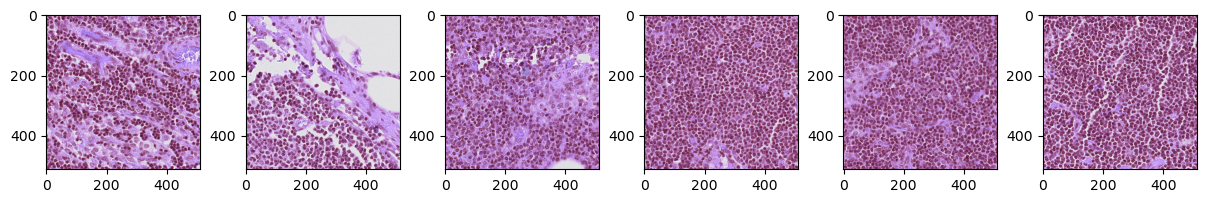

In [19]:
fig, axes = plt.subplots(1,6,figsize=(15,2))

tiles = glob.glob('output/tiles/*')
tiles = tiles[:6]
for i, p in enumerate(tiles):
    tile = cv2.imread(p)
    axes[i].imshow(tile)
    
plt.show()

In [20]:
args.parser = 'uni'
func = parser.extract_features(
    args.parser,
    args.model_path,
    downsample=args.downsample,
    normalize=args.normalize
)

## ROI Annotations with `Annotations`

The `Annotations` class parses region-of-interest (ROI) files in a variety of formats: 
- **Formats**:  
  - ImageJ XML
  - ASAP XML  
  - QuPath JSON  
  - generic JSON
  - CSV
  - or a DataFrame

The class also exposes:
- **Dictionary of polygons**:  
  Access raw ROI coordinates via the `.annotations` property, which yields  
  `{ label → [ [x₁,y₁], [x₂,y₂], … ] }`.

- **Label management**:  
  - Specify a subset of labels at init via `labels=[…]`.  
  - Filter later with `.filter_labels([...])`.  
  - Rename labels in-place with `.rename_labels({ old:new, … })`.  
  - Encode labels to integer class IDs with `encode=True` or `.encode_keys()`.

- **Convenience properties**:  
  - `.keys` / `.values` lists  
  - `.class_key` dictionary mapping each label → unique integer (1-indexed)  
  - `.numbers` count of ROI instances per label  

- **Tabular export**:  
  - `.df()` → a pandas DataFrame of `labels, x, y` for every polygon vertex  
  - `.save(path)` → writes the DataFrame to CSV  

### Initialization

```python
Annotations(
    path,           # str or [str]: path(s) to annotation file(s)
    source,         # "imagej" | "asap" | "qupath" | "json" | "csv" | "_dataframe"
    labels=[],      # optional list of labels to keep
    encode=False    # whether to encode labels → integers
)


In [21]:
qupath_path='test_data/qupath_annotations.json'
asap_path='test_data/asap_annotations.xml'
imagej_path='test_data/imagej_annotations.xml'
json_path='test_data/json_annotations.json'
csv_path='test_data/csv_annotations.csv'

In [22]:
annotate_qupath=Annotations([qupath_path],source="qupath")
annotate_imagej=Annotations([imagej_path],source="imagej")
annotate_asap=Annotations([asap_path],source="asap")
annotate_csv=Annotations([csv_path],source="csv")

In [23]:
annotate_qupath

    classes  number
0  Negative       4
1     Other       3

In [24]:
annotate_imagej

           classes  number
0                        1
1            SINUS      55
2          ADIPOSE       3
3         FOLLICLE      29
4  GERMINAL CENTRE      27

In [25]:
annotate_asap

      classes  number
0  metastases      20
1        None       1

class integer encoding

In [26]:
annotate_imagej.class_key

{'': 1, 'SINUS': 2, 'ADIPOSE': 3, 'FOLLICLE': 4, 'GERMINAL CENTRE': 5}

rename labels

In [27]:
annotate_imagej.rename_labels({'GERMINAL CENTRE':'GC'})
annotate_imagej.class_key

{'': 1, 'SINUS': 2, 'ADIPOSE': 3, 'FOLLICLE': 4, 'GC': 5}

Convert annotations to csv file or Pandas Dataframe

In [28]:
annotate_qupath.df()

,labels,x,y
0,Negative,73993,23888
1,Negative,73925,23895
2,Negative,73859,23914
3,Negative,73836,23926
4,Negative,73831,23928
...,...,...,...
139,Negative,74239,23889
140,Negative,74217,23888
141,Negative,73993,23888
142,Other,77875,23260


In [29]:
annotate_imagej.df()

,labels,x,y
0,,16527,9382
1,,65373,9382
2,,65373,30671
3,,16527,30671
4,SINUS,41981,11394
...,...,...,...
1917,GC,37289,21330
1918,GC,37242,21330
1919,GC,37230,21330
1920,GC,37207,21330


In [30]:
annotate_qupath.save('annotation_coordinates.csv')

## `Slide`: Whole‐Slide Image with Annotation Overlay

The `Slide` class extends `openslide.OpenSlide` to wrap a whole‐slide image (WSI) and its ROI annotations, providing tools to generate masks, borders, and crops:

- **Annotation masks**  
  - `.generate_mask(size=None, labels=[])` → single‐channel NumPy mask (each pixel holds its class ID)  
  - `.slide_mask` → RGB version of the mask (resized to `MASK_SIZE`)  

- **ROI border computation**  
  - `.get_border(space=100)` → bounding box around all annotations, with `space` pixels of padding  
  - `Slide.resize_border(dim, factor, threshold, operator)` → static helper to snap a length to the nearest multiple of `factor` under/over a `threshold`  

- **Region extraction**  
  - `.generate_region(mag=0, x=None, y=None, x_size=None, y_size=None, scale_border=False, factor=1, threshold=None, operator='=>')`  
    Returns `(region_rgb, region_mask)` cropped at the requested location/size (or around the computed border), with optional border scaling.  

- **Component detection**  
  - `.detect_components(level_dims=6, num_component=None, min_size=None)`  
    Downsamples the WSI, thresholds to binary, finds connected contours, and returns a list of contour images plus their level-0 bounding boxes.  

- **Saving thumbnails & masks**  
  - `.save(path, size=(2000,2000), mask=False)`  
    - `mask=False` (default): writes a thumbnail RGB image  
    - `mask=True`: writes the RGB annotation mask  

---

### Initialization

```python
Slide(
    filename: str,               # path to WSI file
    mag: int = 0,                # which downsampling level (0 = native)
    annotations: Annotations = None,
    annotations_path: str = None,
    labels: list = None,
    source: str = None           # passed to Annotations if annotations_path is used
)


In [31]:
QUPATH_PATH=folder_path + 'test_data/qupath_example.json'
WSI_PATH=folder_path + 'test_data/2865_B2_LN.ndpi'

The next cells do the following:

### 1. Load annotations & generate mask

1. **Instantiate** `Annotations` from your QuPath JSON, keeping only the ROI classes you care about.  
   ```python
   annotate = Annotations(
       qupath_path, 
       source="qupath", 
       labels=['sinus', 'follicle', 'germinal centre']
   )

### 2. Visualize slide thumbnail vs. annotation mask

This cell generates a small RGB thumbnail of the WSI and displays it side-by-side with the annotation overlay:

1. **Thumbnail**:  
   ```python
   slide_thumbnail = np.array( wsi.get_thumbnail((200,200)) )


In [32]:
annotate=Annotations([QUPATH_PATH],source="qupath",labels=['sinus','follicle','germinal centre'])
wsi=Slide(WSI_PATH,mag=0,annotations=annotate)
mask=wsi.slide_mask
print('border:{}'.format(wsi.get_border()))

border:[(3981, 118531), (11202, 92659)]


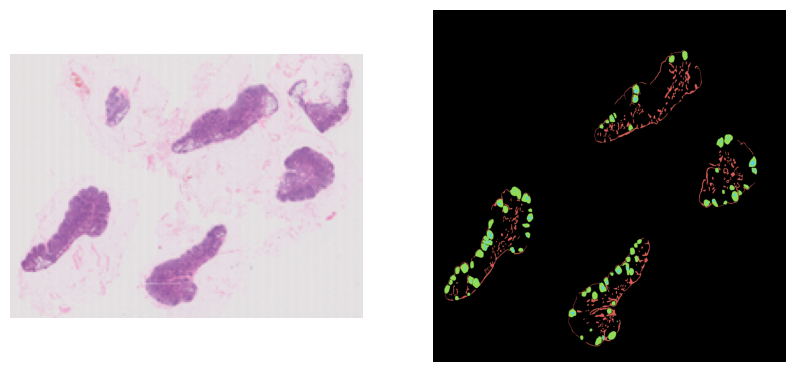

In [33]:
slide_thumbnail=np.array(wsi.get_thumbnail((200,200)))
mask=wsi.slide_mask
fig,axes=plt.subplots(1,2,figsize=(10,10))
axes[0].imshow(slide_thumbnail)
axes[0].axis('off')
axes[1].imshow(mask)
axes[1].axis('off')
plt.show()

### (TODO NOT CURRENTLY WORKING)

Split up WSI into a set of patches
- step size
- magnification
- size
- generate binary/multiclass masks (if annotations exist)
- generate patch labels (if annotations exist)

In [34]:
wsi.get_border()
patch=patching.Patching(wsi,mag_level=3,step=1024,size=(1024,1024))
patch.save('images',mask_flag=True)

NameError: name 'patching' is not defined

#### filter patches

Filter patches based on pixel intensity

In [ ]:
patch.filter_patches(210)
patch.save('images',mask_flag=True)
masks=glob.glob('images/masks/*')
for m in masks:
    mask=cv2.imread(m)
    mask=mask2rgb(mask[:,:,0])
    plt.imshow(mask)
    plt.show()

#### Get labels

Generate patch-level labels based on annotations. Threshold is used to filter patches where class doesn't reach given area of the patch. Where threshold isn't met assign to a new class.

In [ ]:
num=patch.generate_labels(0.6)
patch.plotlabeldist()
print(num)

### Stitching Class

Given a complete set of patches/masks (no filtering and a contiguous set of patch coordinates) we can stitch patches/masks back together into original image.

In [ ]:
stitch=Stitching('images/images', name='2865_B2_LN.ndpi', mag_level=3)
canvas=stitch.stitch(size=(1024,1024))

In [ ]:
plt.imshow(canvas)

### Preprocessing Function

Calculate class imbalance and weights inversley proportional to area of each class

In [ ]:
calculate_weights(mask_path='images/masks',num_cls=4)

In [ ]:
calculate_std_mean('images/images')